### Histogram Calibration

Brier score before calibration: 0.0202
Brier score after calibration: 0.0123


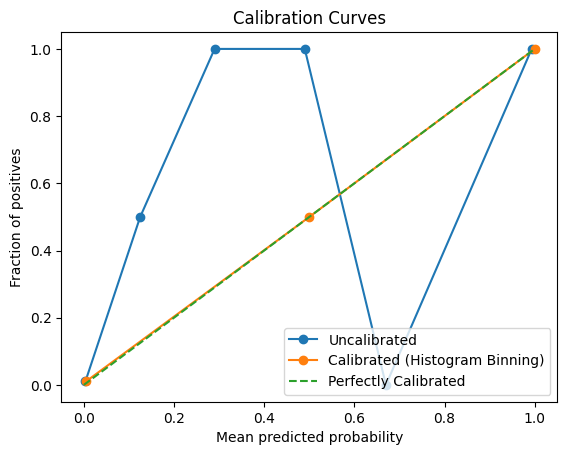

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# Function for Histogram Binning calibration
class HistogramBinning:
    def __init__(self, n_bins=10):
        self.n_bins = n_bins
        self.bin_limits = None
        self.bin_predictions = None

    def fit(self, probabilities, true_labels):
        # Split probabilities into bins
        self.bin_limits = np.linspace(0, 1, self.n_bins + 1)
        self.bin_predictions = np.zeros(self.n_bins)

        # Loop through each bin
        for i in range(self.n_bins):
            bin_mask = (probabilities > self.bin_limits[i]) & (probabilities <= self.bin_limits[i + 1])
            if np.sum(bin_mask) > 0:
                # Mean of true labels in the bin
                self.bin_predictions[i] = np.mean(true_labels[bin_mask])

    def predict(self, probabilities):
        # Calibrate probabilities based on bin predictions
        calibrated_probabilities = np.zeros_like(probabilities)
        for i in range(self.n_bins):
            bin_mask = (probabilities > self.bin_limits[i]) & (probabilities <= self.bin_limits[i + 1])
            calibrated_probabilities[bin_mask] = self.bin_predictions[i]
        return calibrated_probabilities

# Create a synthetic imbalanced dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, 
                           n_clusters_per_class=1, weights=[0.9], flip_y=0, random_state=42)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict uncalibrated probabilities
prob_rf = rf.predict_proba(X_test)[:, 1]

# Apply Histogram Binning calibration
calibrator = HistogramBinning(n_bins=10)
calibrator.fit(prob_rf, y_test)
prob_rf_calibrated = calibrator.predict(prob_rf)

# Calculate Brier Score for both uncalibrated and calibrated models
brier_uncalibrated = brier_score_loss(y_test, prob_rf)
brier_calibrated = brier_score_loss(y_test, prob_rf_calibrated)

print(f"Brier score before calibration: {brier_uncalibrated:.4f}")
print(f"Brier score after calibration: {brier_calibrated:.4f}")

# Plot calibration curves
prob_true_uncalibrated, prob_pred_uncalibrated = calibration_curve(y_test, prob_rf, n_bins=10)
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test, prob_rf_calibrated, n_bins=10)

plt.plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='o', label='Uncalibrated')
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', label='Calibrated (Histogram Binning)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

plt.title('Calibration Curves')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()


### Isotonic Calibration

In [3]:
# Create a synthetic imbalanced dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, 
                           n_clusters_per_class=1, weights=[0.9], flip_y=0, random_state=42)

In [4]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

# Example with a Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Fit a Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Measure uncalibration
prob_true_uncalib, prob_pred_uncalib = calibration_curve(y_test, rf.predict_proba(X_test)[:, 1], n_bins=10)

# Apply calibration using Isotonic Regression
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv='prefit')
calibrated_rf.fit(X_train, y_train)

# Measure calibration
prob_true_calib, prob_pred_calib = calibration_curve(y_test, calibrated_rf.predict_proba(X_test)[:, 1], n_bins=10)

# Compare with uncalibrated model
uncalibrated_prob = rf.predict_proba(X_test)[:, 1]
brier_loss_uncalibrated = brier_score_loss(y_test, uncalibrated_prob)
brier_loss_calibrated = brier_score_loss(y_test, calibrated_rf.predict_proba(X_test)[:, 1])

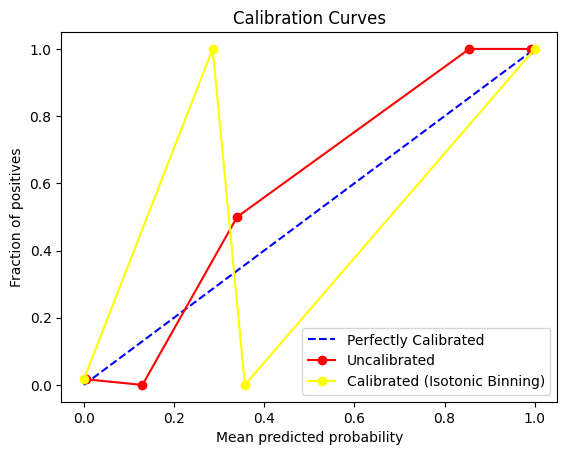

In [6]:
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color = "blue")
plt.plot(prob_pred_uncalib, prob_true_uncalib, marker='o', label='Uncalibrated', color = "red")
plt.plot(prob_pred_calib, prob_true_calib, marker='o', label='Calibrated (Isotonic Binning)', color = "yellow")

plt.title('Calibration Curves')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

### Platt Scaling Calibration

Brier score before calibration: 0.0202
Brier score after calibration: 0.0249


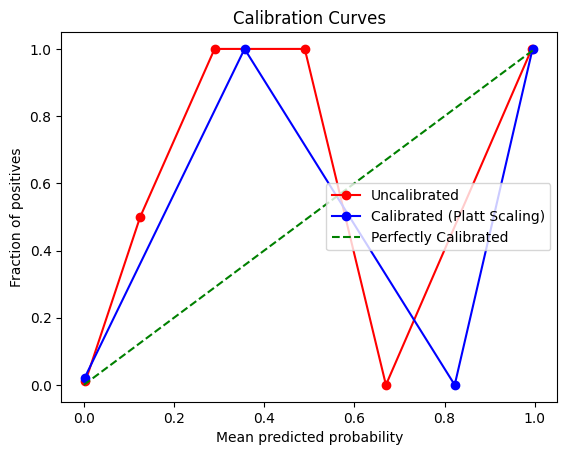

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Create a synthetic imbalanced dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, 
                           n_clusters_per_class=1, weights=[0.9], flip_y=0, random_state=42)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Apply Platt Scaling calibration using CalibratedClassifierCV (default method='sigmoid')
calibrator = CalibratedClassifierCV(rf, method='sigmoid', cv='prefit')
calibrator.fit(X_train, y_train)

# Predict uncalibrated probabilities
prob_rf = rf.predict_proba(X_test)[:, 1]

# Predict calibrated probabilities
prob_rf_calibrated = calibrator.predict_proba(X_test)[:, 1]

# Calculate Brier Score for both uncalibrated and calibrated models
brier_uncalibrated = brier_score_loss(y_test, prob_rf)
brier_calibrated = brier_score_loss(y_test, prob_rf_calibrated)

print(f"Brier score before calibration: {brier_uncalibrated:.4f}")
print(f"Brier score after calibration: {brier_calibrated:.4f}")

# Plot calibration curves
prob_true_uncalibrated, prob_pred_uncalibrated = calibration_curve(y_test, prob_rf, n_bins=10)
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test, prob_rf_calibrated, n_bins=10)

plt.plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='o', label='Uncalibrated', color='r')
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', label='Calibrated (Platt Scaling)', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='green')

plt.title('Calibration Curves')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()
